# Imports

In [1]:
import os
print(os.listdir("../input"))

!git clone https://github.com/mebn/ultralytics.git
!cd ultralytics && git pull && cd ..

import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append("/kaggle/working/ultralytics")
from ultralytics import YOLO

['seadronessee-yolo-2000a']
fatal: destination path 'ultralytics' already exists and is not an empty directory.
Already up to date.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Replacing backbone and initialization

In [2]:
model_file = "/kaggle/working/model.yaml"


with open(model_file, "w") as f:
    f.write("""
nc: 80  # number of classes

scales:
  n: [1, 1, 1024]  # logical name, but actually scaled down below

# YOLO11n backbone (scaled)
backbone:
  # [from, repeats, module, args]
  - [-1, 1, Conv, [16, 3, 2]]              # 64 × 0.25 → 16
  - [-1, 1, Conv, [32, 3, 2]]              # 128 × 0.25 → 32
  - [-1, 1, C3k2, [64, False, 0.25]]       # 2 × 0.5 → 1 repeat, 256 × 0.25 → 64
  - [-1, 1, Conv, [64, 3, 2]]              # 256 × 0.25 → 64
  - [-1, 1, C3k2, [128, False, 0.25]]      # 2 × 0.5 → 1 repeat, 512 × 0.25 → 128
  - [-1, 1, Conv, [128, 3, 2]]             # 512 × 0.25 → 128
  - [-1, 1, C3k2, [128, True]]             # 2 × 0.5 → 1 repeat, 512 × 0.25 → 128
  - [-1, 1, Conv, [256, 3, 2]]             # 1024 × 0.25 → 256
  - [-1, 1, C3k2, [256, True]]             # 2 × 0.5 → 1 repeat
  - [-1, 1, SPPF, [256, 5]]                # 1024 × 0.25 → 256
  - [-1, 1, C2PSA, [256]]                  # 1024 × 0.25 → 256

# YOLO11n head (scaled)
head:
  - [-1, 1, nn.Upsample, [None, 2, "nearest"]]           # 11
  - [[-1, 6], 1, Concat, [1]]
  - [-1, 1, C3k2, [128, False]]                          # 512 × 0.25 → 128

  - [-1, 1, nn.Upsample, [None, 2, "nearest"]]           # 14
  - [[-1, 4], 1, Concat, [1]]
  - [-1, 1, C3k2, [64, False]]                           # 256 × 0.25 → 64

  - [-1, 1, Conv, [64, 3, 2]]                            # 256 × 0.25 → 64
  - [[-1, 13], 1, Concat, [1]]
  - [-1, 1, C3k2, [128, False]]                          # 512 × 0.25 → 128

  - [-1, 1, Conv, [128, 3, 2]]                           # 512 × 0.25 → 128
  - [[-1, 10], 1, Concat, [1]]
  - [-1, 1, C3k2, [256, True]]                           # 1024 × 0.25 → 256

  - [[16, 19, 22], 1, Detect, [nc]]                      # Detect heads: small, medium, large
""")


model = YOLO(model_file, task="detect")

WARNING ⚠️ no model scale passed. Assuming scale='n'.


# Data

In [3]:
data_file = "/kaggle/working/data.yaml"


with open(data_file, "w") as f:
    f.write("""train: /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train
val: /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/val
test: /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/test
nc: 1
names: ["human"]""")

# Fine-tuning

In [4]:
model.train(
    data=data_file,
    epochs=300,
    patience=10,
    imgsz=640,
    batch=16,
    name="model"
)

New https://pypi.org/project/ultralytics/8.3.116 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/model.yaml, data=/kaggle/working/data.yaml, epochs=300, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=model3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fal

100%|██████████| 755k/755k [00:00<00:00, 23.2MB/s]


Overriding model.yaml nc=80 with nc=1
WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]       

train: Scanning /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels/train... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:10<00:00, 191.38it/s]

train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9561.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9563.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9564.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9565.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9569.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9570.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9571.jpg: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels/val... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:01<00:00, 139.02it/s]

val: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/val/9560.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels is not writeable, cache not saved.


Plotting labels to /kaggle/working/model3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/model3
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.46G      4.364      41.62      2.985        152        640: 100%|██████████| 125/125 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]

                   all        250       1262   0.000368     0.0166    0.00057    0.00017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300       2.7G      3.498       3.69      1.407        123        640: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.29it/s]

                   all        250       1262      0.226      0.175     0.0836     0.0184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300       2.7G      3.241      2.606      1.266        135        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.34it/s]


                   all        250       1262      0.271      0.264      0.134     0.0305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300       2.7G      3.058      2.104      1.209        156        640: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.13it/s]


                   all        250       1262      0.345      0.259      0.166     0.0385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300       2.7G      2.939      1.864      1.183        143        640: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]


                   all        250       1262       0.43      0.313      0.225     0.0593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300       2.7G      2.839      1.685      1.149        152        640: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.72it/s]

                   all        250       1262      0.419      0.367      0.283     0.0812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300       2.7G      2.796      1.604      1.145        118        640: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]

                   all        250       1262      0.465      0.373      0.303     0.0872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300       2.7G      2.711      1.503      1.126        167        640: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.28it/s]

                   all        250       1262      0.462      0.372      0.309     0.0943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300       2.7G      2.692      1.468      1.087        135        640: 100%|██████████| 125/125 [00:58<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.89it/s]

                   all        250       1262      0.543      0.391      0.347      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300       2.7G       2.64      1.428      1.077        114        640: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.26it/s]


                   all        250       1262      0.525      0.365      0.312     0.0912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300       2.7G      2.654      1.412      1.098        109        640: 100%|██████████| 125/125 [00:58<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.44it/s]


                   all        250       1262      0.482      0.399      0.364      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300       2.7G       2.58      1.372      1.072        114        640: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.26it/s]

                   all        250       1262       0.53      0.415      0.356     0.0995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300       2.7G      2.564      1.358      1.076        116        640: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.34it/s]

                   all        250       1262      0.508      0.434      0.387      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300       2.7G       2.53      1.321      1.071        157        640: 100%|██████████| 125/125 [00:56<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.59it/s]


                   all        250       1262      0.529      0.414       0.38       0.11

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300       2.7G       2.48      1.271      1.044        101        640: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.56it/s]

                   all        250       1262      0.565      0.422      0.413      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300       2.7G      2.508      1.288      1.062        143        640: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.20it/s]


                   all        250       1262      0.541       0.42      0.379      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300       2.7G       2.48      1.278      1.044        141        640: 100%|██████████| 125/125 [00:56<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.86it/s]

                   all        250       1262      0.578      0.432      0.404      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300       2.7G      2.449       1.25      1.048        113        640: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.55it/s]

                   all        250       1262      0.536      0.393      0.347       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300       2.7G       2.41      1.246      1.045        114        640: 100%|██████████| 125/125 [00:56<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]

                   all        250       1262      0.572      0.448      0.425      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300       2.7G      2.465      1.239      1.048        133        640: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.78it/s]

                   all        250       1262       0.61      0.456      0.447      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300       2.7G      2.445      1.234      1.054         99        640: 100%|██████████| 125/125 [00:57<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]

                   all        250       1262      0.596      0.446      0.419      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300       2.7G      2.344      1.173      1.032        126        640: 100%|██████████| 125/125 [00:57<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.10it/s]


                   all        250       1262      0.617      0.464      0.455      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300       2.7G      2.374      1.196      1.041        128        640: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]

                   all        250       1262      0.608      0.472      0.467      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300       2.7G      2.368      1.192      1.029        153        640: 100%|██████████| 125/125 [00:57<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.18it/s]

                   all        250       1262      0.635      0.465      0.461      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300       2.7G       2.37      1.175      1.033        131        640: 100%|██████████| 125/125 [00:59<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]

                   all        250       1262      0.622      0.467      0.469      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300       2.7G      2.348      1.151      1.016        118        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.46it/s]

                   all        250       1262      0.608      0.484      0.481      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300       2.7G       2.33      1.152      1.026        161        640: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

                   all        250       1262      0.651      0.474      0.475      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300       2.7G      2.345      1.138      1.009        112        640: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.18it/s]

                   all        250       1262       0.61      0.493      0.483      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300       2.7G       2.34      1.155      1.018        146        640: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

                   all        250       1262      0.641      0.496        0.5      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300       2.7G      2.308      1.152      1.022        133        640: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.58it/s]

                   all        250       1262      0.639       0.48      0.486      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300       2.7G      2.273      1.129      1.021        154        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

                   all        250       1262       0.62      0.449      0.469      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300       2.7G      2.288       1.12      1.019        122        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.48it/s]


                   all        250       1262       0.65      0.505      0.493      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300       2.7G      2.304      1.116      1.023        203        640: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.28it/s]

                   all        250       1262      0.586      0.471      0.449      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300       2.7G      2.268        1.1     0.9988        200        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

                   all        250       1262      0.643      0.479      0.479      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300       2.7G      2.288      1.106     0.9973        148        640: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]

                   all        250       1262       0.64      0.482      0.493      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300       2.7G      2.247      1.095      1.008        163        640: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]

                   all        250       1262      0.665      0.515       0.53       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300       2.7G      2.239      1.085     0.9981        133        640: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

                   all        250       1262      0.651      0.494      0.503      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300       2.7G      2.249      1.083      1.007        122        640: 100%|██████████| 125/125 [00:56<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.20it/s]

                   all        250       1262      0.603        0.5      0.491      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300       2.7G      2.226      1.075     0.9955        126        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.85it/s]

                   all        250       1262      0.635      0.456      0.467      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300       2.7G      2.241      1.089       1.01        169        640: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.98it/s]

                   all        250       1262       0.68       0.48      0.491      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300       2.7G      2.221      1.079      1.013        152        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

                   all        250       1262      0.677      0.521      0.527      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300       2.7G      2.243      1.077      1.013        110        640: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.43it/s]

                   all        250       1262      0.655      0.506      0.518      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300       2.7G      2.206       1.07      1.002        139        640: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.76it/s]

                   all        250       1262      0.639      0.506       0.51      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300       2.7G      2.186      1.057      1.001        140        640: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.39it/s]

                   all        250       1262      0.656      0.509      0.512      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300       2.7G      2.218      1.064     0.9953        109        640: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]

                   all        250       1262      0.669      0.512      0.509      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300       2.7G      2.227      1.075      1.005        142        640: 100%|██████████| 125/125 [00:55<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.86it/s]

                   all        250       1262      0.681      0.515      0.519      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300       2.7G      2.233       1.07      1.006        106        640: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.36it/s]

                   all        250       1262      0.632      0.514      0.509      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300       2.7G      2.187      1.049     0.9976        179        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.23it/s]

                   all        250       1262      0.692      0.507      0.529      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300       2.7G      2.195      1.057      1.004        140        640: 100%|██████████| 125/125 [00:55<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]

                   all        250       1262      0.676      0.536      0.542      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300       2.7G      2.183      1.039     0.9806        125        640: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

                   all        250       1262      0.666       0.51      0.518      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300       2.7G      2.148      1.027     0.9983        140        640: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]

                   all        250       1262      0.679      0.505      0.529      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300       2.7G      2.158      1.032     0.9909        194        640: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.36it/s]

                   all        250       1262      0.639      0.514      0.516      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300       2.7G      2.191      1.046     0.9977        110        640: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]

                   all        250       1262      0.671      0.519      0.542      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300       2.7G      2.151      1.019     0.9916        125        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.37it/s]


                   all        250       1262      0.681      0.478      0.497      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300       2.7G       2.16      1.034     0.9929        138        640: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]

                   all        250       1262      0.636      0.516      0.536      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300       2.7G      2.143      1.021     0.9774        119        640: 100%|██████████| 125/125 [00:58<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.32it/s]

                   all        250       1262      0.668      0.519      0.535      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300       2.7G      2.156      1.012     0.9771        153        640: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

                   all        250       1262      0.713      0.536      0.563      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300       2.7G      2.143      1.012     0.9806        121        640: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.52it/s]


                   all        250       1262      0.694      0.526      0.546      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300       2.7G       2.15      1.009     0.9845        130        640: 100%|██████████| 125/125 [00:58<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.77it/s]

                   all        250       1262      0.691      0.526      0.553      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300       2.7G      2.127      1.015     0.9817        131        640: 100%|██████████| 125/125 [00:58<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.29it/s]

                   all        250       1262      0.675      0.529      0.552      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300       2.7G      2.178       1.03     0.9798        126        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.79it/s]


                   all        250       1262      0.664       0.54      0.536      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300       2.7G      2.128      1.009      0.992         95        640: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.32it/s]

                   all        250       1262       0.69      0.513      0.542      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300       2.7G      2.142      1.013     0.9762        133        640: 100%|██████████| 125/125 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]

                   all        250       1262       0.68      0.519      0.535      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300       2.7G      2.131      1.018     0.9911        128        640: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.94it/s]

                   all        250       1262      0.676      0.536      0.548      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300       2.7G      2.133     0.9974     0.9786        125        640: 100%|██████████| 125/125 [00:58<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

                   all        250       1262      0.709      0.533      0.557      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300       2.7G      2.142      1.012     0.9957        135        640: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.46it/s]

                   all        250       1262      0.689      0.537      0.574      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300       2.7G      2.096     0.9981     0.9804        152        640: 100%|██████████| 125/125 [00:54<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.44it/s]


                   all        250       1262      0.652      0.523      0.535      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300       2.7G      2.089     0.9798     0.9859        137        640: 100%|██████████| 125/125 [00:58<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.26it/s]

                   all        250       1262      0.706      0.537      0.563      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300       2.7G      2.108     0.9914     0.9816        163        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.81it/s]

                   all        250       1262      0.681      0.543      0.547      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300       2.7G      2.132      1.021     0.9894        135        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.58it/s]

                   all        250       1262      0.705      0.525      0.553      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300       2.7G       2.14      1.009     0.9679        101        640: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]

                   all        250       1262      0.704      0.529      0.554      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300       2.7G      2.102     0.9815     0.9701        136        640: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.38it/s]

                   all        250       1262      0.694      0.516      0.557      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300       2.7G      2.125      0.987     0.9825        135        640: 100%|██████████| 125/125 [00:57<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.27it/s]

                   all        250       1262       0.69       0.54      0.571      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300       2.7G      2.089     0.9884     0.9885         85        640: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.89it/s]

                   all        250       1262      0.673      0.552      0.565      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300       2.7G      2.114     0.9851     0.9738         95        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

                   all        250       1262      0.681      0.531      0.552      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300       2.7G      2.113     0.9813      0.974        152        640: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.77it/s]

                   all        250       1262      0.685      0.532      0.552      0.218
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 66, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



76 epochs completed in 1.252 hours.
Optimizer stripped from /kaggle/working/model3/weights/last.pt, 5.5MB
Optimizer stripped from /kaggle/working/model3/weights/best.pt, 5.5MB

Validating /kaggle/working/model3/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary (fused): 100 layers, 2,582,347 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


                   all        250       1262      0.688      0.536      0.573      0.226


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /kaggle/working/model3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x787fd4bd0130>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Testing

In [5]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


image 1/1 /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/test/10209.jpg: 384x640 7 humans, 41.9ms
Speed: 2.3ms preprocess, 41.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


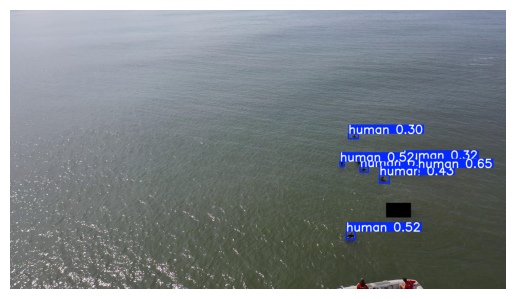

Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels/test... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:01<00:00, 125.63it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]


                   all        250       1350      0.708      0.615      0.622      0.241


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 3.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x787fd4272140>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.03

In [7]:
model = YOLO("/kaggle/working/model3/weights/best.pt")

img = "/kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/test/10209.jpg"

results = model(img)
show_img_with_boxes(results)

metrics = model.val(
    data=data_file,
    split="test"
)

print(metrics)